In [1]:
#!pip3 install numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pprint as pprint
pp = pprint.PrettyPrinter(indent=4)
from datetime import datetime
from datetime import timedelta
import RPi.GPIO as GPIO
import time
import progressbar
import inspect, re
#import signal


%matplotlib inline  

In [127]:
####config for signal time############
def signal_handler(signum, frame):
    raise Exception("Timeout!")
signal.signal(signal.SIGALRM, signal_handler)


#assign pin numbers
msd501pm10pin=5
msd501pm25pin=6
nova10pin=23
nova25pin=24




In [132]:
##############config system#############


def setupGPIO(pin,mode): #mode is either in or out
    GPIO.setmode(GPIO.BCM)
    if mode=="in": 
        GPIO.setup(pin, GPIO.IN)
    else:
        GPIO.setup(pin, GPIO.OUT)

        
        
###### data processing######################
def varname(p):
  for line in inspect.getframeinfo(inspect.currentframe().f_back)[3]:
    m = re.search(r'\bvarname\s*\(\s*([A-Za-z_][A-Za-z0-9_]*)\s*\)', line)
    if m:
      return m.group(1)



def checkarray(pulseinfonova): #### check the generated array
    print(pulseinfonova['pulsewidth10'])
    print(pulseinfonova['pulsewidth25'],"\n\n")
    pp.pprint(pulseinfonova)
    
#generate dataframe
def generatedf(pulseinfonova):
    df=pd.DataFrame({'time':pulseinfonova['time'],
                  'pulsewidth10':pulseinfonova['pulsewidth10'],
                  'pulsewidth25':pulseinfonova['pulsewidth25'],
                  'dust10(ng)':pulseinfonova['pulsewidth10']-2000,
                  'dust10(ug)':(pulseinfonova['pulsewidth10']-2000)/1000,
                  'dust25(ng)':pulseinfonova['pulsewidth25']-2000,
                  'dust25(ug)':(pulseinfonova['pulsewidth25']-2000)/1000,  
                  "time(s)":pulseinfonova['second']/1000})
    #add info
    df["dust10(ppm)"]=df['dust10(ug)']*1.225
    df["dust25(ppm)"]=df['dust25(ug)']*1.225
    df["rolling mean 10(ppm)"] = df["dust10(ppm)"].rolling(10,center=True).mean()
    df["rolling mean 25(ppm)"] = df["dust25(ppm)"].rolling(10,center=True).mean()
    df.fillna(method='bfill',inplace=True)
    df["error10"]= np.power(np.power(df["rolling mean 10(ppm)"]-df["dust10(ppm)"],2),0.4)
    df["error25"]= np.power(np.power(df["rolling mean 25(ppm)"]-df["dust25(ppm)"],2),0.4)
    #fill in na just in case
    df.fillna(method='bfill',inplace=True)
    df.fillna(method='ffill',inplace=True)
    return df


############ reading the pins#######        


def readpulse(pin):   ###read high pulse width
    for i in range(2):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000000


def readpulsewidth(pin10,pin25,number_of_readings): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time)*1000)
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second}


def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1000 and pulsereading25 > 1000:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.5
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25}



def readpulselow(pin): ## read low pulse width
    for i in range(1):
        start = datetime.now()
        stop = datetime.now()
        while GPIO.input(pin) == 1:
            continue
        start = datetime.now()
        while GPIO.input(pin) == 0:
            continue
        stop = datetime.now()
        Elapsed = stop - start
    return Elapsed.total_seconds()*1000



def check_low_pulse_for(pin,period):#period in seconds #check low ratio in active low circuits over a period #return dict
    start=datetime.now()
    #signal.alarm(period)
    activeperiod=0
    while (datetime.now()-start).total_seconds()<period:
        activeperiod+=readpulselow(pin)
    
    totalperiod=(datetime.now()-start).total_seconds()*1000
    #print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
    return {'lowpulse':activeperiod,'total_period':totalperiod,'ratio':activeperiod/totalperiod}
    

    
def readlowsensorasdf(pin,size,period):###output dataframe from readings with specified repitition and period return df
    readings=[]
    output_dict={}
    for i in range(size):
        readings.append(check_low_pulse_for(msd501pm10pin,period))
    for i in readings[0].keys():
        output_dict[i]=[]
    for i in readings:
        for j in i.keys():
            output_dict[j].append(i[j])
    return pd.DataFrame(output_dict)    
    

####### debug functions#####


def infinite_loop():
    start=datetime.now()
    try:
        while True:
            print('the time is {time}'.format(time=(start-datetime.now()).total_seconds()))
            time.sleep(1)
    
    except Exception:
        print ("Timeout! at {time_elasped}".format(time_elasped=(datetime.now()-start).total_seconds()))
        
        
def testpulse(pin,periods):
    #end_time = datetime.now() + timedelta(seconds=20)
    count=0
    while count<periods:
        #time.sleep(1)
        #print(GPIO.input(23))
        dustlevel= float(readpulse(pin)+1-1)-2
        print("the dust level is :", dustlevel)
        count+=1

def testlowpulse(pin,times=5):
    for i in times:
        Lowpulse = readpulselow(pin)
        print(Lowpulse)

In [126]:
#set up gpio
pin_input=[msd501pm10pin, msd501pm25pin, nova10pin,nova25pin]
pin_name=['msd501pm10pin', 'msd501pm25pin', 'nova10pin','nova25pin']
for pin in pin_input:
    setupGPIO(pin,"in")

In [102]:
#run test for output
for pin,name in zip(pin_input,pin_name):
    print(name)
    testpulse(pin,5)

msd501pm10pin
the dust level is : 6.007
the dust level is : 6.040000000000001
the dust level is : 6.071999999999999
the dust level is : 6.048
the dust level is : 6.0440000000000005
msd501pm25pin
the dust level is : 6.75
the dust level is : 6.715999999999999
the dust level is : 6.661
the dust level is : 6.680999999999999
the dust level is : 6.670999999999999
nova10pin
the dust level is : 24.996
the dust level is : 24.99
the dust level is : 24.988000000000003
the dust level is : 24.989
the dust level is : 24.983
nova25pin
the dust level is : 27.978
the dust level is : 26.986
the dust level is : 26.99
the dust level is : 26.985
the dust level is : 26.992


In [140]:
#set data variables
datasize=1000

#call data
#pulseinfonova=readpulsewidth(nova10pin,nova25pin,datasize)
pulseinfonova=read_pulsewidth_and_pulse_time(datasize,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)
checkarray(pulseinfonova)
df=generatedf(pulseinfonova)

100% (1000 of 1000) |####################| Elapsed Time: 1:27:22 Time:  1:27:22


[27002. 26975. 27985. 27986. 27991. 27988. 27989. 27986. 27990. 27989.
 28990. 28988. 28986. 28989. 28984. 27991. 27994. 27985. 26991. 26991.
 25989. 25989. 25990. 25986. 25987. 25989. 25989. 25987. 26990. 26987.
 26990. 26986. 26991. 26990. 26993. 26995. 26988. 26993. 26988. 27992.
 26993. 27990. 27990. 27985. 27992. 26991. 26990. 26992. 26993. 26994.
 26988. 26984. 26992. 25990. 25989. 25989. 25998. 25989. 26993. 26990.
 27989. 27991. 27988. 27989. 28992. 27992. 27992. 27991. 28990. 28990.
 29990. 29990. 29989. 29985. 28989. 27988. 27993. 26995. 26992. 27993.
 27990. 27985. 27996. 27980. 27985. 27991. 27991. 27985. 27991. 27997.
 27986. 27985. 28987. 27988. 27991. 27997. 27996. 26993. 26996. 27992.
 27992. 27987. 28994. 28989. 28983. 28990. 27989. 27996. 26995. 26992.
 26994. 26995. 26992. 27002. 26999. 26994. 27988. 27996. 27991. 27987.
 26991. 26986. 25990. 26981. 26986. 26983. 26986. 26988. 26993. 26984.
 26988. 26984. 26991. 26987. 26996. 25990. 25991. 25988. 26987. 27987.
 27985

{   'pulsetime10': array([0.59271012, 0.59333346, 0.60354911, 0.59478834, 0.59510026,
       0.59384924, 0.59329653, 0.59843049, 0.5919468 , 0.59305417,
       0.59773637, 0.59329586, 0.59440318, 0.59043085, 0.59833396,
       0.59776836, 0.5968896 , 0.59619565, 0.60044712, 0.60405781,
       0.60220613, 0.60452767, 0.59930037, 0.60130504, 0.59602461,
       0.59486776, 0.59748739, 0.60030906, 0.60279099, 0.59291678,
       0.60129859, 0.59877804, 0.60430669, 0.60420761, 0.6060947 ,
       0.60348434, 0.59936649, 0.60093912, 0.59986694, 0.61048478,
       0.59795166, 0.59800814, 0.59979199, 0.60018173, 0.60451102,
       0.59697331, 0.59432939, 0.59796701, 0.60065875, 0.59806271,
       0.5982066 , 0.60436929, 0.60167707, 0.59769234, 0.59805171,
       0.59301669, 0.59575598, 0.59943751, 0.60182179, 0.593106  ,
       0.59548269, 0.60008567, 0.59889461, 0.59384742, 0.60242275,
       0.60259204, 0.60144921, 0.60660453, 0.60033931, 0.60587447,
       0.60515321, 0.60081411, 0.59871715, 

    'pulsetime25': array([0.55448202, 0.55820703, 0.56121148, 0.56060188, 0.55825047,
       0.56669328, 0.57011905, 0.56193641, 0.56627111, 0.56393264,
       0.57357414, 0.56203977, 0.56220993, 0.57449223, 0.56295907,
       0.56717826, 0.56934113, 0.56838143, 0.56719925, 0.56637986,
       0.56388014, 0.57702567, 0.57827447, 0.57630579, 0.56816281,
       0.56349728, 0.572245  , 0.56548146, 0.56460913, 0.56884151,
       0.56597677, 0.57344857, 0.57440186, 0.56638738, 0.56469147,
       0.56356406, 0.5701437 , 0.57430374, 0.56428765, 0.56696829,
       0.5683047 , 0.56019124, 0.56565015, 0.56559367, 0.57599547,
       0.57051619, 0.56901127, 0.56537744, 0.56537427, 0.56542649,
       0.5656035 , 0.56108465, 0.57179689, 0.56949869, 0.56560082,
       0.57098839, 0.56808124, 0.56942813, 0.56937783, 0.56855562,
       0.56760179, 0.56494111, 0.57248599, 0.57452632, 0.561308  ,
       0.56897144, 0.57084476, 0.56446456, 0.56375639, 0.56346057,
       0.56718206, 0.56540846, 0.56466628, 

    'pulsewidth25': array([29979., 29983., 29990., 29987., 30984., 29990., 30988., 30991.,
       30990., 30985., 31988., 31989., 31988., 31981., 30987., 30984.,
       29985., 29988., 28985., 29987., 28992., 28986., 28986., 28983.,
       28985., 28984., 28992., 28988., 28989., 29988., 29994., 28987.,
       29992., 29993., 29994., 29989., 28991., 29993., 29988., 29992.,
       29992., 30992., 30994., 30990., 29987., 29989., 29986., 28990.,
       28988., 28986., 29987., 28990., 28992., 28986., 28991., 28993.,
       28992., 28993., 28989., 29984., 29990., 30992., 30988., 30987.,
       30987., 30992., 30989., 30990., 31987., 31989., 32987., 32996.,
       32984., 32989., 31988., 30983., 30989., 29989., 29987., 30992.,
       30993., 30993., 30999., 30992., 30992., 30989., 30991., 30992.,
       30995., 30989., 30989., 30981., 30985., 30990., 30988., 30993.,
       29996., 29992., 29993., 29992., 30997., 30991., 31993., 31990.,
       31993., 30995., 30990., 29998., 29996., 29995., 28

                '2019-02-02 14:40:19',
                '2019-02-02 14:40:25',
                '2019-02-02 14:40:30',
                '2019-02-02 14:40:35',
                '2019-02-02 14:40:40',
                '2019-02-02 14:40:45',
                '2019-02-02 14:40:51',
                '2019-02-02 14:40:57',
                '2019-02-02 14:41:02',
                '2019-02-02 14:41:07',
                '2019-02-02 14:41:12',
                '2019-02-02 14:41:17',
                '2019-02-02 14:41:22',
                '2019-02-02 14:41:27',
                '2019-02-02 14:41:32',
                '2019-02-02 14:41:37',
                '2019-02-02 14:41:42',
                '2019-02-02 14:41:47',
                '2019-02-02 14:41:52',
                '2019-02-02 14:41:57',
                '2019-02-02 14:42:02',
                '2019-02-02 14:42:07',
                '2019-02-02 14:42:12',
                '2019-02-02 14:42:17',
                '2019-02-02 14:42:22',
                '2019-02-

                '2019-02-02 15:17:05',
                '2019-02-02 15:17:10',
                '2019-02-02 15:17:15',
                '2019-02-02 15:17:20',
                '2019-02-02 15:17:25',
                '2019-02-02 15:17:31',
                '2019-02-02 15:17:37',
                '2019-02-02 15:17:43',
                '2019-02-02 15:17:49',
                '2019-02-02 15:17:54',
                '2019-02-02 15:17:59',
                '2019-02-02 15:18:04',
                '2019-02-02 15:18:09',
                '2019-02-02 15:18:15',
                '2019-02-02 15:18:21',
                '2019-02-02 15:18:26',
                '2019-02-02 15:18:31',
                '2019-02-02 15:18:37',
                '2019-02-02 15:18:43',
                '2019-02-02 15:18:49',
                '2019-02-02 15:18:54',
                '2019-02-02 15:18:59',
                '2019-02-02 15:19:04',
                '2019-02-02 15:19:09',
                '2019-02-02 15:19:14',
                '2019-02-

In [141]:
df.head(5)

,dust10(ng),dust10(ug),dust25(ng),dust25(ug),pulsewidth10,pulsewidth25,time,time(s),dust10(ppm),dust25(ppm),rolling mean 10(ppm),rolling mean 25(ppm),error10,error25
0,25002.0,25.002,27979.0,27.979,27002.0,29979.0,2019-02-02 14:12:36,2.724132,30.627450,34.274275,31.590422,34.896207,0.970267,0.683903
1,24975.0,24.975,27983.0,27.983,26975.0,29983.0,2019-02-02 14:12:41,7.741535,30.594375,34.279175,31.590422,34.896207,0.996837,0.679589
2,25985.0,25.985,27990.0,27.990,27985.0,29990.0,2019-02-02 14:12:46,12.759450,31.831625,34.287750,31.590422,34.896207,0.320557,0.672023
3,25986.0,25.986,27987.0,27.987,27986.0,29987.0,2019-02-02 14:12:51,17.778266,31.832850,34.284075,31.590422,34.896207,0.321859,0.675268
4,25991.0,25.991,28984.0,28.984,27991.0,30984.0,2019-02-02 14:12:56,22.797594,31.838975,35.505400,31.590422,34.896207,0.328348,0.672672


In [142]:
#save file
filename="./data/test{time}.csv".format(time=datetime.now().strftime("%d%b%y_%H:%M"))
df.to_csv(filename)

In [88]:
#load file
filename='./data/test02Feb19_00:01.csv'
df=pd.read_csv(filename)

In [136]:
df.head()

,dust10(ng),dust10(ug),dust25(ng),dust25(ug),pulsewidth10,pulsewidth25,time,time(s),dust10(ppm),dust25(ppm),rolling mean 10(ppm),rolling mean 25(ppm),error10,error25
0,24987.0,24.987,27993.0,27.993,26987.0,29993.0,2019-02-02 14:10:16,2.919156,30.609075,34.291425,30.732678,34.040423,0.187768,0.330935
1,24989.0,24.989,27985.0,27.985,26989.0,29985.0,2019-02-02 14:10:21,7.937650,30.611525,34.281625,30.732678,34.040423,0.184785,0.320557
2,24995.0,24.995,27992.0,27.992,26995.0,29992.0,2019-02-02 14:10:26,12.956306,30.618875,34.290200,30.732678,34.040423,0.175761,0.329642
3,24982.0,24.982,26985.0,26.985,26982.0,28985.0,2019-02-02 14:10:31,17.973920,30.602950,33.056625,30.732678,34.040423,0.195176,0.987017
4,23988.0,23.988,26987.0,26.987,25988.0,28987.0,2019-02-02 14:10:36,22.991918,29.385300,33.059075,30.732678,34.040423,1.269379,0.985050


In [137]:
def plotchart(df):
    #create charts to show the distribution of the readings
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 10))
    sns.set(style="darkgrid")
    #Plot against dust (line)
    sns.relplot(x="time(s)", y="dust10(ppm)",kind="line",data=df,ax=ax1)
    sns.relplot(x="time(s)", y="rolling mean 10(ppm)",kind="line",color="coral",data=df,ax=ax1)
    sns.lineplot(x="time(s)", y="rolling mean 10(ppm)",color="coral",data=df,ax=ax2)
    ax2.errorbar(df["time(s)"],y=df["rolling mean 10(ppm)"],yerr=df["error10"],color="c")
    ax1.set_title("moving average vs raw data")
    return[ax1,ax2]

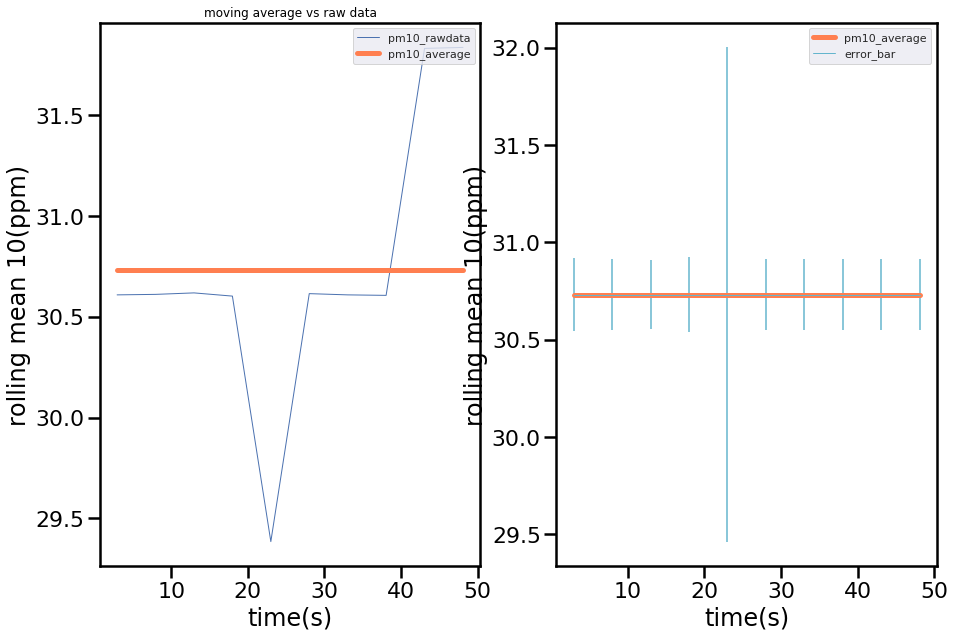

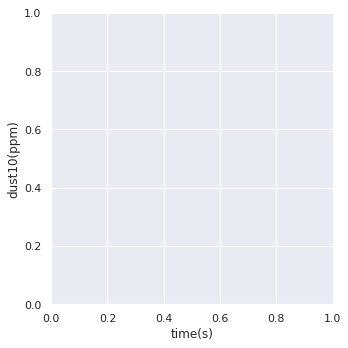

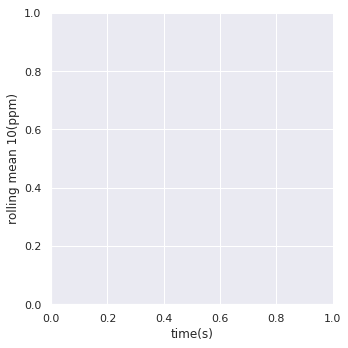

In [138]:
ax1,ax2=plotchart(df)
#ax1.lines[0].get_linewidth()
plt.setp(ax1.lines[0],linewidth=1)
plt.setp(ax1.lines[1],linewidth=5)
plt.setp(ax2.lines[0],linewidth=5)
plt.setp(ax2.lines[1],linewidth=1)
ax1.legend(handles=ax1.lines, labels=["pm10_rawdata","pm10_average"],loc='upper right')
ax2.legend(handles=ax2.lines, labels=["pm10_average","error_bar"],loc='upper right')

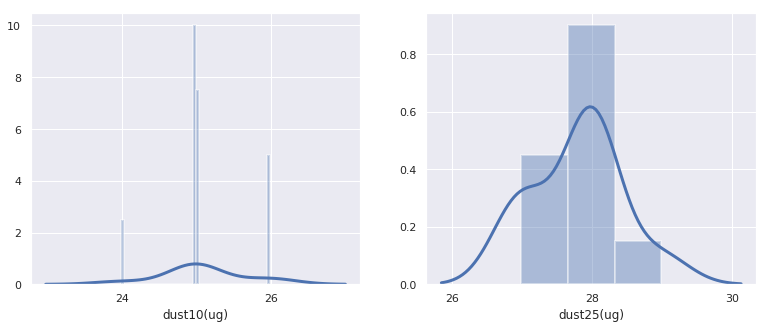

In [139]:
f, axes = plt.subplots(1, 2,figsize=(13, 5))
sns.set_context("poster")
sns.distplot(df["dust10(ug)"],ax=axes[0])
sns.distplot(df["dust25(ug)"],ax=axes[1])

# READ dm501

In [45]:
msd501pm10_reading=check_low_pulse_for(msd501pm10pin,2)
print(msd501pm10_reading)

{'ratio': 0.5875662179808938, 'total_period': 2000.212, 'lowpulse': 1175.2569999999996}


In [75]:
pprint.pprint(readings)  

[{'lowpulse': 1173.841999999999,
  'ratio': 0.5868722895999626,
  'total_period': 2000.1660000000002},
 {'lowpulse': 1175.1959999999988,
  'ratio': 0.5875589273313319,
  'total_period': 2000.133},
 {'lowpulse': 1175.6359999999988,
  'ratio': 0.5877777372249995,
  'total_period': 2000.137},
 {'lowpulse': 1180.7599999999998,
  'ratio': 0.5903428084030705,
  'total_period': 2000.1259999999997},
 {'lowpulse': 1178.1299999999985,
  'ratio': 0.5890261242757971,
  'total_period': 2000.1319999999998},
 {'lowpulse': 1183.9279999999997,
  'ratio': 0.5919261167285291,
  'total_period': 2000.1280000000002},
 {'lowpulse': 1181.0960000000005,
  'ratio': 0.5905107978197377,
  'total_period': 2000.1259999999997},
 {'lowpulse': 1186.303000000001,
  'ratio': 0.593112354584598,
  'total_period': 2000.1319999999998},
 {'lowpulse': 1184.2010000000007,
  'ratio': 0.5920620159689624,
  'total_period': 2000.1299999999999},
 {'lowpulse': 1184.540999999999,
  'ratio': 0.5922337815055462,
  'total_period': 2000.

In [82]:

readings_df=readlowsensorasdf(msd501pm10pin,10000,0.1)
readings_df.describe()

,lowpulse,ratio,total_period
count,10000.000000,10000.000000,10000.000000
mean,65.506176,0.600163,109.048443
std,5.883107,0.035426,5.649903
min,58.848000,0.544536,100.020000
25%,60.055000,0.558190,107.784000
50%,60.768500,0.601161,107.929000
75%,71.868000,0.639889,112.090000
max,73.510000,0.653215,120.102000


In [85]:
readings_df.to_csv("./data/readings_df{datetime}.csv".format(datetime=datetime.now().strftime("%d%b%y_%H:%M")))

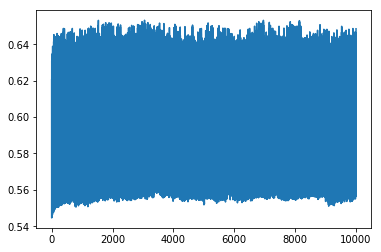

In [83]:
ax=plt.plot(readings_df['ratio'])

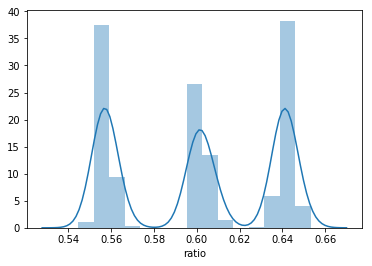

In [86]:
sns.distplot(readings_df['ratio']);

In [123]:
def read_pulsewidth_and_pulse_time(number_of_readings,pin10=None,pin25=None,pinmsd10=None,pinmsd25=None): ###read high pulse width (2 at the same time)
    pulsewidth10=np.array([])
    pulsewidth25=np.array([])
    pulsetime10=np.array([])
    pulsetime25=np.array([])
    time=[]
    second=np.array([])
    start_time=datetime.now()
    with progressbar.ProgressBar(max_value=number_of_readings) as bar:
        while True:
            startreadtime=datetime.now()
            pulsereading10=readpulse(pin10)
            pulsereading25=readpulse(pin25)
            if pulsereading10 > 1 and pulsereading25 > 1:
                pulsewidth10=np.append(pulsewidth10,pulsereading10)
                pulsewidth25=np.append(pulsewidth25,pulsereading25)
                time_for_pulseread=(datetime.now()-startreadtime).total_seconds()*0.5
                time.append(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                second=np.append(second,(datetime.now()-start_time).total_seconds()*1000)
                if pinmsd10:
                    pulsetime10=np.append(pulsetime10,check_low_pulse_for(pinmsd10,time_for_pulseread)["ratio"])                   
                if pinmsd25:
                    pulsetime25=np.append(pulsetime25,check_low_pulse_for(pinmsd25,time_for_pulseread)["ratio"])
            if pulsewidth10.size>= number_of_readings:
                break
            bar.update(pulsewidth10.size)
            #print("currently at loop",pulsewidth10.size)
    return {"pulsewidth10":pulsewidth10,"pulsewidth25":pulsewidth25,"time":time,"second":second,"pulsetime10":pulsetime10,"pulsetime25":pulsetime25}

In [124]:
read_pulsewidth_and_pulse_time(5,nova10pin,nova25pin,msd501pm10pin,msd501pm25pin)


pin10 is read 27.985
pin25 is read 30.979
1.0368665
pulse10 is read


N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

pulse25 is read
pin10 is read 27.976
pin25 is read 30.973
1.457234
pulse10 is read


 40% (2 of 5) |##########                | Elapsed Time: 0:00:05 ETA:   0:00:08

pulse25 is read
pin10 is read 27.979
pin25 is read 30.979
1.037069
pulse10 is read


 60% (3 of 5) |###############           | Elapsed Time: 0:00:10 ETA:   0:00:08

pulse25 is read
pin10 is read 27.982
pin25 is read 30.98
1.468241
pulse10 is read


 80% (4 of 5) |####################      | Elapsed Time: 0:00:15 ETA:   0:00:05

pulse25 is read
pin10 is read 27.976999999999997
pin25 is read 30.979
1.0272225
pulse10 is read


100% (5 of 5) |##########################| Elapsed Time: 0:00:20 Time:  0:00:20


pulse25 is read


{'pulsetime10': array([0.58634406, 0.59170871, 0.59095303, 0.59372239, 0.59400292]),
 'pulsetime25': array([0.55996166, 0.55496657, 0.55676298, 0.55742841, 0.55734262]),
 'pulsewidth10': array([27.985, 27.976, 27.979, 27.982, 27.977]),
 'pulsewidth25': array([30.979, 30.973, 30.979, 30.98 , 30.979]),
 'second': array([ 2074.719,  7091.951, 12109.061, 17126.548, 22143.94 ]),
 'time': ['2019-02-02 14:00:41',
  '2019-02-02 14:00:46',
  '2019-02-02 14:00:51',
  '2019-02-02 14:00:56',
  '2019-02-02 14:01:01']}